# IEEE For Fraud Detection

## Reference
- https://medium.com/@mr.priyankmishra/a-realistic-approach-to-ieee-cis-fraud-detection-25faea54137
- https://www.kaggle.com/competitions/ieee-fraud-detection/data

The datasets provided by the Competiton Host are as follows,

- **train_transaction.csv** : The transaction dataset comprising the transaction details to be used for training the model.
- **train_identity.csv** : The identity dataset comprising the additional details about the identity of the payer and the merchant between whom the transaction was performed and the details of transactions are present in the train_transaction.csv.
- **test_transaction.csv** : The transaction dataset comprising the transaction information to test the performance of the trained model.
- **test_identity.csv** : The identity dataset comprising the additional identity information about the transactions present in the test_transaction.


## Description of Transaction Dataset

- **TransactionID** — Id of the transaction and is the foreign key in the Identity Dataset.
- **isFraud** — 0 or 1 signifying whether a transaction is fraudulent or not.
TransactionDT — timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAmt** — Transaction Payment Amount in USD.
- **ProductCD** — Product Code.
- **card1** — card6 — Payment Card information, such as card type, card category, issue bank, country, etc.
- **addr** — Address
- **dist** — Distance
- **P_emaildomain** — Purchaser Email Domain.
- **R_emaildomain** — Receiver Email Domain.
- **C1-C14** — counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- **D1-D15** — timedelta, such as days between previous transactions, etc.
- **M1-M9** — match, such as names on card and address, etc.
- **V1-V339** — Vesta engineered rich features, including ranking, counting, and other entity relations.


Following Features are Categorical in the Transaction Dataset,


- **ProductCD**
- **card1-card6**
- **addr1, addr2**
- **P_emaildomain**
- **R_emaildomain**
- **M1-M9**

Description of the Identity Dataset

Following Features are present in the Identity Dataset,

- **TransactionID** — Foreign key to the Transaction Dataset.
- **id_01-id_38** — Masked features corresponding to the identity of the card holders.
- **DeviceType** — Type of Device used to make the Transaction.
- **DeviceInfo** — Information regarding the characteristics of the Device.


Following Features are Categorical in the Identity Dataset,


- **DeviceType**
- **DeviceInfo**
- **id_12 — id_38**


Variables in this table are identity information — network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They’re collected by Vesta’s fraud protection system and digital security partners.


(The field names are masked and a pairwise dictionary is not provided for privacy protection and contract agreement).

## Node and Edge Definitions for DGL Graph


#### **Node Features** (Entity Properties)

#### **Card Nodes:**
- `card1-card6` (payment card information)
- `addr1, addr2` (addresses associated with cards)
- Aggregated transaction statistics per card (mean/sum TransactionAMT, transaction frequency, etc.)

#### **Email Domain Nodes:**
- `P_emaildomain, R_emaildomain` (purchaser/receiver email domains)
- Domain-level aggregated features (transaction volume, fraud rates)

#### **Device Nodes:**
- `DeviceType, DeviceInfo`
- `id_01-id_38` (masked identity features - these likely contain device fingerprinting info)

#### **User/Identity Nodes:**
- Identity-related features from the identity dataset
- Behavioral patterns aggregated at user level

### **Edge Features** (Transaction Properties)

#### **Transaction Edges** (connecting relevant entities):
- `TransactionAMT` (transaction amount)
- `TransactionDT` (time delta)
- `ProductCD` (product code)
- `C1-C14` (counting features - relationships between entities)
- `D1-D15` (time deltas between transactions)
- `M1-M9` (matching features between entities)
- `V1-V339` (Vesta's engineered relationship features)
- `dist` (distance features)

### **Graph Structure Recommendations:**

1. **Card ↔ Transaction ↔ Email Domain**: Connect cards to email domains through transaction edges
2. **Card ↔ Device**: When the same card is used on multiple devices
3. **Email Domain ↔ Device**: When the same email is used across devices
4. **Temporal Edges**: Connect sequential transactions from the same entity

### **Hybrid Approach:**

Since you're combining GNN + XGBoost:

- **GNN Component**: Use the graph structure to learn entity embeddings and relationship patterns
- **XGBoost Component**: Use both:
  - Original tabular features (transaction-level)
  - GNN-generated embeddings as additional features

The `V1-V339` features are particularly valuable as they're already engineered relationship features from Vesta, making them perfect candidates for both edge features and XGBoost input.

This structure allows the GNN to capture network effects (like cards frequently transacting with suspicious email domains) while XGBoost handles the complex non-linear patterns in the tabular data.


In [1]:
# Check if CUDA is available. Change Runtime to TPU

!nvidia-smi

Tue Sep 16 21:13:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# https://pytorch.org/get-started/previous-versions/
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176

In [3]:

# Install DGL for Cuda 12.4, torch 2.4.x
# https://www.dgl.ai/pages/start.html
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 MB 3.0 MB/s eta 0:00:00


In [ ]:
import os

root_path = "./machine-learning/gnns-dgl/datasets/ieee-fraud-detection/"
!ls {root_path}

transaction_path = os.path.join(root_path, "train_transaction.csv")
identity_path = os.path.join(root_path, "train_identity.csv")

sample_submission.csv  test_transaction.csv  train_transaction.csv
test_identity.csv      train_identity.csv


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/tmp/ipython-input-2167625417.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.df['DeviceInfo_simple'] = self.df['DeviceInfo'].astype(str).str.lower().str.split('/', n=1).str[0].fillna('unknown')


Loaded data: (590540, 435), Frauds: 20663, Fraud %: 3.50
Split: train 472,432, val 118,108
Nodes (train-only): cards=13698, emails=60, devices=1591, txns=472432
Graph created: nodes=487781, edges=2834592


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


GNN supervised training: pos_weight=27.580 (train neg=455902, pos=16530)
[GNN] Epoch 10/80 loss=1.333552 train_AP=0.0419
[GNN] Epoch 20/80 loss=1.330796 train_AP=0.0434
[GNN] Epoch 30/80 loss=1.325510 train_AP=0.0484
[GNN] Epoch 40/80 loss=1.322265 train_AP=0.0513
[GNN] Epoch 50/80 loss=1.325001 train_AP=0.0477
[GNN] Epoch 60/80 loss=1.329361 train_AP=0.0467
[GNN] Epoch 70/80 loss=1.324768 train_AP=0.0537
[GNN] Epoch 80/80 loss=1.320771 train_AP=0.0519
GNN training finished.
Sample weights stats: min=0.518, max=14.290
scale_pos_weight = 27.580 (neg=455902, pos=16530)


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [21:20:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [21:21:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Comparing balanced vs unbalanced approaches...
Unbalanced Model:
  AUC: 0.9313
  Average Precision: 0.6610

Balanced Model:
  AUC: 0.9257
  Average Precision: 0.5648

Improvement:
  AUC: -0.0056
  Average Precision: -0.0963 (-14.6%)


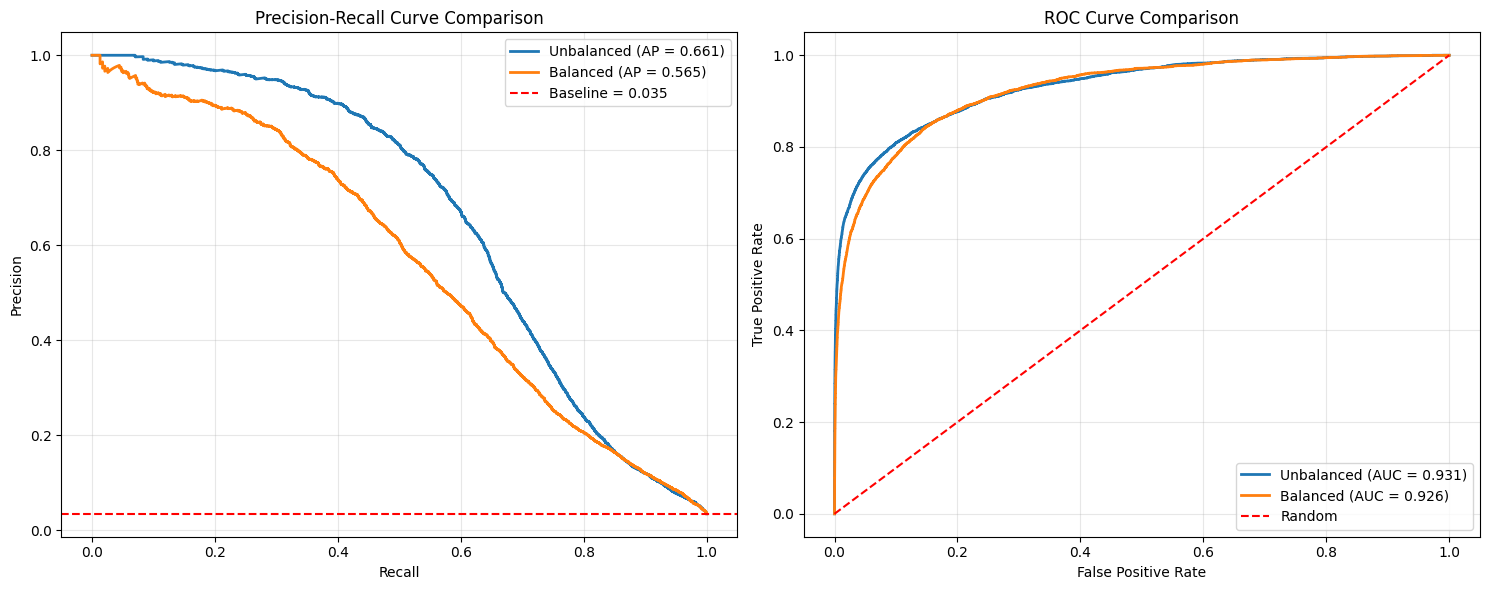

Spearman rho between score orderings: 0.8710491779635163


{'unbalanced': {'auc': np.float64(0.931295114138382),
  'ap': np.float64(0.6610380511787444)},
 'balanced': {'auc': np.float64(0.9256684605160919),
  'ap': np.float64(0.5647608432729296)}}

In [5]:
import os
import math
from collections import Counter
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import GraphConv
import xgboost as xgb
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    confusion_matrix, classification_report, f1_score
)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Helpful device / seed utils
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RNG_SEED = 42
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

def compare_balanced_vs_unbalanced(
    X_val, y_val, balanced_model, unbalanced_model):
        """Compare balanced vs unbalanced training approaches"""
        print("Comparing balanced vs unbalanced approaches...")

        # Predictions
        y_pred_unbalanced = unbalanced_model.predict_proba(X_val)[:, 1]
        y_pred_balanced   = balanced_model.predict_proba(X_val)[:, 1]

        # Metrics
        auc_unbalanced = roc_auc_score(y_val, y_pred_unbalanced)
        auc_balanced = roc_auc_score(y_val, y_pred_balanced)

        ap_unbalanced = average_precision_score(y_val, y_pred_unbalanced)
        ap_balanced = average_precision_score(y_val, y_pred_balanced)

        print(f"Unbalanced Model:")
        print(f"  AUC: {auc_unbalanced:.4f}")
        print(f"  Average Precision: {ap_unbalanced:.4f}")

        print(f"\nBalanced Model:")
        print(f"  AUC: {auc_balanced:.4f}")
        print(f"  Average Precision: {ap_balanced:.4f}")

        print(f"\nImprovement:")
        print(f"  AUC: {auc_balanced - auc_unbalanced:+.4f}")
        print(f"  Average Precision: {ap_balanced - ap_unbalanced:+.4f} ({((ap_balanced/ap_unbalanced)-1)*100:+.1f}%)")

        # Plot comparison
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Precision-Recall curves
        precision_unb, recall_unb, _ = precision_recall_curve(y_val, y_pred_unbalanced)
        precision_bal, recall_bal, _ = precision_recall_curve(y_val, y_pred_balanced)

        axes[0].plot(recall_unb, precision_unb, linewidth=2, label=f'Unbalanced (AP = {ap_unbalanced:.3f})')
        axes[0].plot(recall_bal, precision_bal, linewidth=2, label=f'Balanced (AP = {ap_balanced:.3f})')
        axes[0].axhline(y=y_val.mean(), color='r', linestyle='--', label=f'Baseline = {y_val.mean():.3f}')
        axes[0].set_xlabel('Recall')
        axes[0].set_ylabel('Precision')
        axes[0].set_title('Precision-Recall Curve Comparison')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # ROC curves
        fpr_unb, tpr_unb, _ = roc_curve(y_val, y_pred_unbalanced)
        fpr_bal, tpr_bal, _ = roc_curve(y_val, y_pred_balanced)

        axes[1].plot(fpr_unb, tpr_unb, linewidth=2, label=f'Unbalanced (AUC = {auc_unbalanced:.3f})')
        axes[1].plot(fpr_bal, tpr_bal, linewidth=2, label=f'Balanced (AUC = {auc_balanced:.3f})')
        axes[1].plot([0, 1], [0, 1], 'r--', label='Random')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].set_title('ROC Curve Comparison')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # after you have y_pred_proba for unbalanced and balanced
        rho, p = st.spearmanr(y_pred_unbalanced, y_pred_balanced)
        print("Spearman rho between score orderings:", rho)

        return {
            'unbalanced': {'auc': auc_unbalanced, 'ap': ap_unbalanced},
            'balanced': {'auc': auc_balanced, 'ap': ap_balanced}
        }


# -------------------------
# DataPreparationPipeline
# -------------------------
class DataPreparationPipeline:
    """
    Loads data, imputes, splits rows into train/val (time-agnostic random stratified split by default).
    Provides helpers to:
      - compute train-only aggregates
      - map embeddings back to full transaction rows (val rows get zero embeddings if entities unseen)
      - create X_train/X_val and sample weights safely
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.train_idx = None
        self.val_idx = None
        self.df = None
        self.train_df = None
        self.val_df = None
        self.label_encoders = {}

    def load_and_preprocess_data(self, transaction_path: str, identity_path: str):
        """Read CSVs and perform deterministic, safe imputation (no label-derived transforms)."""
        tr = pd.read_csv(transaction_path)
        idf = pd.read_csv(identity_path)
        self.df = tr.merge(idf, on='TransactionID', how='left')
        self._fill_missing_values()
        print(f"Loaded data: {self.df.shape}, Frauds: {int(self.df['isFraud'].sum())}, Fraud %: {self.df['isFraud'].mean()*100:.2f}")

    def _fill_missing_values(self):
        """Simple imputation for categories and numericals (median)."""
        categorical_cols = ['ProductCD'] + [f'card{i}' for i in range(1, 7)] + ['addr1','addr2','P_emaildomain','R_emaildomain'] + \
                           [f'M{i}' for i in range(1, 10)] + ['DeviceType','DeviceInfo'] + [f'id_{i:02d}' for i in range(12, 39)]
        for c in categorical_cols:
            if c in self.df.columns:
                self.df[c] = self.df[c].fillna('unknown')

        numerical_cols = ['TransactionAmt'] + [f'C{i}' for i in range(1, 15)] + [f'D{i}' for i in range(1, 16)] + \
                         [f'V{i}' for i in range(1, 340)] + [f'id_{i:02d}' for i in range(1, 12)]
        for c in numerical_cols:
            if c in self.df.columns:
                self.df[c] = self.df[c].fillna(self.df[c].median())

        # Quick device_info cleanup (reduce cardinality)
        if 'DeviceInfo' in self.df.columns:
            self.df['DeviceInfo_simple'] = self.df['DeviceInfo'].astype(str).str.lower().str.split('/', n=1).str[0].fillna('unknown')
        else:
            self.df['DeviceInfo_simple'] = 'unknown'

        if 'DeviceType' not in self.df.columns:
            self.df['DeviceType'] = 'unknown'

    def split_df_for_train_val(self, test_size: float = 0.2, random_state: int = RNG_SEED, time_col: str = None):
        """
        Split rows into train/val.
        If `time_col` provided, performs time-based split (recommended for temporal integrity).
        Otherwise uses stratified random split by isFraud.
        """
        if time_col and time_col in self.df.columns:
            # time-based split: sort by time and pick earlier chunk for training
            df_sorted = self.df.sort_values(time_col).reset_index(drop=True)
            split_idx = int(len(df_sorted) * (1 - test_size))
            self.train_idx = df_sorted.index[:split_idx].to_numpy()
            self.val_idx = df_sorted.index[split_idx:].to_numpy()
            # Need to keep indexes aligned with original df; map sorted back:
            self.train_idx = df_sorted.iloc[:split_idx].index.to_numpy()
            self.val_idx = df_sorted.iloc[split_idx:].index.to_numpy()
        else:
            idx = np.arange(len(self.df))
            train_idx, val_idx = train_test_split(idx, test_size=test_size, random_state=random_state, stratify=self.df['isFraud'])
            self.train_idx = np.sort(train_idx)
            self.val_idx = np.sort(val_idx)

        self.train_df = self.df.iloc[self.train_idx].reset_index(drop=True)
        self.val_df = self.df.iloc[self.val_idx].reset_index(drop=True)
        print(f"Split: train {len(self.train_df):,}, val {len(self.val_df):,}")
        return self.train_df, self.val_df

    def fit_label_encoders_on_train(self, categorical_cols: List[str]):
        """Fit label encoders on train_df and keep them for transforming val/test later (no leakage)."""
        for col in categorical_cols:
            if col in self.train_df.columns:
                le = LabelEncoder()
                le.fit(self.train_df[col].astype(str).fillna('unknown'))
                self.label_encoders[col] = le

    def transform_column_with_encoder(self, col, series):
        """Safe transform using previously fitted encoder; unseen labels -> 'unknown' handling."""
        if col not in self.label_encoders:
            # fallback: label encode on-the-fly using training uniques only
            uniques = self.train_df[col].astype(str).fillna('unknown').unique().tolist()
            le = LabelEncoder(); le.fit(uniques + ['__UNKNOWN__'])
            self.label_encoders[col] = le

        le = self.label_encoders[col]
        vals = series.astype(str).fillna('unknown').tolist()
        # map unseen to '__UNKNOWN__' if present in le classes else to index 0
        mapped = []
        for v in vals:
            if v in le.classes_:
                mapped.append(v)
            else:
                # if '__UNKNOWN__' in classes use it; else use 'unknown' if present; else first class
                if '__UNKNOWN__' in le.classes_:
                    mapped.append('__UNKNOWN__')
                elif 'unknown' in le.classes_:
                    mapped.append('unknown')
                else:
                    mapped.append(le.classes_[0])
        return le.transform(mapped)

    def create_training_sample_weights(self):
        """Compute per-sample weights using train labels only and sklearn balanced scheme."""
        classes = np.array([0,1])
        class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=self.y_train)
        weight_map = {cls: w for cls, w in zip(classes, class_weights)}
        sample_weights = np.array([weight_map[y] for y in self.y_train], dtype=float)
        self.sample_weights = sample_weights
        print(f"Sample weights stats: min={sample_weights.min():.3f}, max={sample_weights.max():.3f}")
        return self.sample_weights

    def calculate_class_pos_weight(self):
        """scale_pos_weight for xgboost and pos_weight for BCEWithLogitsLoss computed from y_train."""
        neg = int((self.y_train == 0).sum())
        pos = int((self.y_train == 1).sum())
        self.scale_pos_weight = float(neg) / float(max(1, pos))
        print(f"scale_pos_weight = {self.scale_pos_weight:.3f} (neg={neg}, pos={pos})")
        return self.scale_pos_weight

    def split_sets_using_saved_idx(self, transaction_features: np.ndarray):
        """
        Use saved train_idx/val_idx to build X_train/X_val and y_train/y_val.
        Fit scaler on X_train only to avoid leakage.
        """
        if self.train_idx is None:
            raise RuntimeError("Call split_df_for_train_val() first.")

        X_train = transaction_features[self.train_idx]
        X_val = transaction_features[self.val_idx]
        y_train = self.df['isFraud'].values[self.train_idx]
        y_val = self.df['isFraud'].values[self.val_idx]

        # Fit scaler on train only
        self.scaler.fit(X_train)
        X_train_s = self.scaler.transform(X_train)
        X_val_s = self.scaler.transform(X_val)

        self.X_train, self.X_val, self.y_train, self.y_val = X_train_s, X_val_s, y_train, y_val
        return self.X_train, self.X_val, self.y_train, self.y_val

# -------------------------
# GNN model (detailed explanation below)
# -------------------------
class GNNModel(nn.Module):
    """
    GraphConv-based GNN with configurable layers, dropout, and optional batchnorm.
    It returns node embeddings (one vector per node).
    """
    def __init__(self, in_feats: int, hidden_size: int, out_feats: int, num_layers: int = 2, dropout: float = 0.2, use_bn: bool = False):
        super(GNNModel, self).__init__()
        self.layers = nn.ModuleList()
        self.use_bn = use_bn
        # input layer
        self.layers.append(GraphConv(in_feats, hidden_size, allow_zero_in_degree=True))
        if self.use_bn:
            self.bn0 = nn.BatchNorm1d(hidden_size)
        # middle layers
        for _ in range(max(0, num_layers - 2)):
            self.layers.append(GraphConv(hidden_size, hidden_size, allow_zero_in_degree=True))
        # output layer
        self.layers.append(GraphConv(hidden_size, out_feats, allow_zero_in_degree=True))
        self.dropout = nn.Dropout(dropout)
        if self.use_bn:
            self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_size) for _ in range(max(0, num_layers - 2) + 1)])  # plus first

    def forward(self, g: dgl.DGLGraph, features: torch.Tensor):
        """
        Forward pass:
          - Apply GraphConv layers sequentially
          - Apply BatchNorm (if enabled), ReLU and dropout after each hidden layer
          - Return final embeddings (no activation applied to final layer)
        """
        h = features
        for i, layer in enumerate(self.layers):
            h = layer(g, h)  # message passing + linear projection
            # apply BN/activation/dropout on all but final layer
            if i < len(self.layers) - 1:
                if self.use_bn:
                    h = self.bns[i](h)
                h = F.relu(h)
                h = self.dropout(h)
        return h

# -------------------------
# GraphPipeline (train-only graph, supervised transaction-node training)
# -------------------------
class GraphPipeline:
    """
    Build a graph using train_df only. Nodes: cards, emails, devices, transactions (transaction nodes help supervised training).
    Edges: transaction <-> card, transaction <-> device, transaction <-> email.
    Node features:
      - transaction nodes: simple tabular features (C/D/V/TransactionAmt/DT)
      - entity nodes (card/email/device): aggregated features computed from train_df (fraud_rate, counts, amt_mean)
    Training:
      - supervised GNN on transaction node labels (BCEWithLogitsLoss with pos_weight derived from train labels)
      - after training, return entity embeddings to map back to val transactions via card/device embeddings
    """
    def __init__(self, train_df: pd.DataFrame, gnn_hidden: int = 64, gnn_out: int = 32, device=DEVICE):
        self.train_df = train_df.reset_index(drop=True)
        self.node_mappings = {}
        self.gnn_hidden = gnn_hidden
        self.gnn_out = gnn_out
        self.graph = None
        self.gnn_model = None
        self.device = device
        # small classifier head to convert embeddings -> single logit for transaction nodes
        # we'll initialize it after we know gnn_out (but keep attribute)
        self.classifier = None
        # which transaction features to include for transaction node features
        self.txn_feature_cols = ['TransactionAmt', 'TransactionDT'] + [f'C{i}' for i in range(1,6)] + [f'D{i}' for i in range(1,6)] + [f'V{i}' for i in range(1,6)]

    def create_node_mappings(self):
        """Create node id -> index mappings from train_df only. Includes transaction nodes at the end."""
        # cards
        cards = self.train_df[['card1','card2','card3','card4']].drop_duplicates().fillna('unknown')
        cards['card_id'] = cards.apply(lambda x: f"card_{x['card1']}_{x['card2']}_{x['card3']}_{x['card4']}", axis=1)
        card_to_idx = {cid: i for i, cid in enumerate(cards['card_id'].unique())}

        # emails
        emails = self.train_df['P_emaildomain'].fillna('unknown').unique()
        email_to_idx = {dom: i + len(card_to_idx) for i, dom in enumerate(emails)}

        # devices (use DeviceInfo_simple to reduce cardinality)
        devices = self.train_df[['DeviceType','DeviceInfo_simple']].drop_duplicates().fillna('unknown')
        devices['device_id'] = devices.apply(lambda x: f"device_{x['DeviceType']}_{x['DeviceInfo_simple']}", axis=1)
        device_to_idx = {did: i + len(card_to_idx) + len(email_to_idx) for i, did in enumerate(devices['device_id'].unique())}

        # transaction nodes (one per train row) appended after entity nodes
        txn_to_idx = {f"txn_{i}": i + len(card_to_idx) + len(email_to_idx) + len(device_to_idx) for i in range(len(self.train_df))}

        self.node_mappings = {
            'card_to_idx': card_to_idx,
            'email_to_idx': email_to_idx,
            'device_to_idx': device_to_idx,
            'txn_to_idx': txn_to_idx
        }
        num_nodes = len(card_to_idx) + len(email_to_idx) + len(device_to_idx) + len(txn_to_idx)
        print(f"Nodes (train-only): cards={len(card_to_idx)}, emails={len(email_to_idx)}, devices={len(device_to_idx)}, txns={len(txn_to_idx)}")
        return num_nodes

    def create_node_features(self, num_nodes, node_feat_dim: int = 64):
        """
        Build a node feature matrix:
         - entity nodes: aggregated train-only stats (amt_mean, count, fraud_rate)
         - transaction nodes: raw txn features listed in self.txn_feature_cols, padded/normalized later
        """
        # initialize
        node_features = torch.zeros(num_nodes, node_feat_dim, dtype=torch.float32)

        # --- entity aggregates from train_df only ---
        # Card aggregates
        cdf = self.train_df[['card1','card2','card3','card4','TransactionAmt','isFraud']].fillna(0)
        card_stats = cdf.groupby(['card1','card2','card3','card4']).agg(
            amt_mean=('TransactionAmt','mean'),
            amt_count=('TransactionAmt','count'),
            fraud_rate=('isFraud','mean'),
            fraud_count=('isFraud','sum')
        ).reset_index().fillna(0)
        for _, r in card_stats.iterrows():
            cid = f"card_{r['card1']}_{r['card2']}_{r['card3']}_{r['card4']}"
            idx = self.node_mappings['card_to_idx'].get(cid)
            if idx is not None:
                vals = torch.tensor([r['amt_mean'], r['amt_count'], r['fraud_rate'], r['fraud_count']], dtype=torch.float32)
                node_features[idx, :4] = vals

        # Email aggregates
        if 'P_emaildomain' in self.train_df.columns:
            edf = self.train_df[['P_emaildomain','TransactionAmt','isFraud']].fillna('unknown')
            email_stats = edf.groupby('P_emaildomain').agg(
                amt_mean=('TransactionAmt','mean'), amt_count=('TransactionAmt','count'), fraud_rate=('isFraud','mean')
            ).reset_index().fillna(0)
            for _, r in email_stats.iterrows():
                idx = self.node_mappings['email_to_idx'].get(r['P_emaildomain'])
                if idx is not None:
                    node_features[idx, 4:7] = torch.tensor([r['amt_mean'], r['amt_count'], r['fraud_rate']], dtype=torch.float32)

        # Device aggregates (DeviceInfo_simple)
        if 'DeviceInfo_simple' in self.train_df.columns:
            dv = self.train_df[['DeviceType','DeviceInfo_simple','TransactionAmt','isFraud']].fillna('unknown')
            dv_stats = dv.groupby(['DeviceType','DeviceInfo_simple']).agg(
                amt_mean=('TransactionAmt','mean'), amt_count=('TransactionAmt','count'), fraud_rate=('isFraud','mean')
            ).reset_index().fillna(0)
            dv_stats['device_id'] = dv_stats.apply(lambda x: f"device_{x['DeviceType']}_{x['DeviceInfo_simple']}", axis=1)
            for _, r in dv_stats.iterrows():
                idx = self.node_mappings['device_to_idx'].get(r['device_id'])
                if idx is not None:
                    node_features[idx, 7:10] = torch.tensor([r['amt_mean'], r['amt_count'], r['fraud_rate']], dtype=torch.float32)

        # --- transaction node features (raw transaction features from train_df) ---
        txn_base_idx = len(self.node_mappings['card_to_idx']) + len(self.node_mappings['email_to_idx']) + len(self.node_mappings['device_to_idx'])
        for i, row in self.train_df.iterrows():
            idx = txn_base_idx + i
            feats = []
            for col in self.txn_feature_cols:
                feats.append(float(row.get(col, 0.0) or 0.0))
            # place transaction features in first len(txn_feature_cols) dims
            tx_tensor = torch.tensor(feats, dtype=torch.float32)
            node_features[idx, :len(feats)] = tx_tensor

        return node_features

    def create_edges(self):
        """
        Create bidirectional edges between txn<->card, txn<->device, txn<->email using train_df only.
        Return src, dst, and edge feature list (small txn features repeated per edge).
        """
        src = []
        dst = []
        edge_feats = []
        txn_base_idx = len(self.node_mappings['card_to_idx']) + len(self.node_mappings['email_to_idx']) + len(self.node_mappings['device_to_idx'])
        for i, row in self.train_df.iterrows():
            txn_idx = txn_base_idx + i
            # card
            card_id = f"card_{row['card1']}_{row['card2']}_{row['card3']}_{row['card4']}"
            card_idx = self.node_mappings['card_to_idx'].get(card_id)
            # device
            device_id = f"device_{row.get('DeviceType','unknown')}_{row.get('DeviceInfo_simple','unknown')}"
            device_idx = self.node_mappings['device_to_idx'].get(device_id)
            # email
            email_dom = row.get('P_emaildomain','unknown')
            email_idx = self.node_mappings['email_to_idx'].get(email_dom)

            # small edge feature vector
            ef = [float(row.get('TransactionAmt',0.0) or 0.0), float(row.get('TransactionDT',0.0) or 0.0)]

            if card_idx is not None:
                src += [txn_idx, card_idx]; dst += [card_idx, txn_idx]
                edge_feats += [ef, ef]
            if device_idx is not None:
                src += [txn_idx, device_idx]; dst += [device_idx, txn_idx]
                edge_feats += [ef, ef]
            if email_idx is not None:
                src += [txn_idx, email_idx]; dst += [email_idx, txn_idx]
                edge_feats += [ef, ef]
        return src, dst, edge_feats

    def create_graph(self):
        """Build DGL graph from train_df only and attach node/edge features."""
        num_nodes = self.create_node_mappings()
        node_feats = self.create_node_features(num_nodes)
        src, dst, edge_feats = self.create_edges()
        if len(src) > 0:
            self.graph = dgl.graph((src, dst), num_nodes=num_nodes).to(self.device)
            self.graph.ndata['feat'] = node_feats.to(self.device)
            if edge_feats:
                self.graph.edata['feat'] = torch.tensor(edge_feats, dtype=torch.float32).to(self.device)
        else:
            # fallback
            self.graph = dgl.graph(([],[]), num_nodes=num_nodes).to(self.device)
            self.graph.ndata['feat'] = node_feats.to(self.device)
        print(f"Graph created: nodes={self.graph.num_nodes()}, edges={self.graph.num_edges()}")
        return self.graph


    def train_gnn(self, epochs: int = 100, lr: float = 1e-3, batch_print: int = 10, supervised: bool = True):
        """
        Train the GNN.
        If supervised=True: trains on transaction nodes only using BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
        If supervised=False: performs simple unsupervised reconstruction (MSE) on node features.
        """
        in_feats = self.graph.ndata['feat'].shape[1]
        # build model
        self.gnn_model = GNNModel(in_feats, self.gnn_hidden, self.gnn_out, num_layers=3, dropout=0.2, use_bn=True).to(self.device)

        # create small classifier head: embedding_dim -> 1 logit (for transactions)
        # If classifier was created earlier, reuse; else init new.
        if self.classifier is None:
            self.classifier = nn.Linear(self.gnn_out, 1).to(self.device)

        params = list(self.gnn_model.parameters()) + list(self.classifier.parameters())
        optim = torch.optim.AdamW(params, lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=10, verbose=False)

        # Prepare supervised training masks/labels for transaction nodes
        txn_to_idx = self.node_mappings['txn_to_idx']
        txn_indices = np.array([txn_to_idx[f"txn_{i}"] for i in range(len(self.train_df))], dtype=int)
        txn_labels = torch.tensor(self.train_df['isFraud'].values, dtype=torch.float32).to(self.device)

        # pos_weight for BCE (pos_weight = neg/pos) -> pass to loss
        neg = int((txn_labels == 0).sum().item())
        pos = int((txn_labels == 1).sum().item())
        pos_weight = torch.tensor([float(neg) / float(max(1,pos))], dtype=torch.float32).to(self.device)
        print(f"GNN supervised training: pos_weight={pos_weight.item():.3f} (train neg={neg}, pos={pos})")

        # loss function
        bce_loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

        for epoch in range(1, epochs+1):
            self.gnn_model.train()
            self.classifier.train()
            optim.zero_grad()

            node_emb = self.gnn_model(self.graph, self.graph.ndata['feat'])  # [num_nodes, out_dim]

            if supervised:
                # map embeddings -> single logit per txn using classifier head
                logits = self.classifier(node_emb[txn_indices]).squeeze(-1)  # -> [num_txn]
                loss = bce_loss_fn(logits, txn_labels)
            else:
                target = self.graph.ndata['feat'][:, :self.gnn_out]
                loss = F.mse_loss(node_emb, target)

            loss.backward()
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(list(self.gnn_model.parameters()) + list(self.classifier.parameters()), max_norm=5.0)
            optim.step()

            # scheduler step uses scalar loss; convert to python float
            scheduler.step(loss.item())

            if epoch % batch_print == 0 or epoch == epochs:
                # optionally compute some training metrics (e.g. train AP) every N epochs to monitor
                if supervised:
                    with torch.no_grad():
                        self.gnn_model.eval(); self.classifier.eval()
                        logits_eval = self.classifier(node_emb[txn_indices]).squeeze(-1)
                        probs = torch.sigmoid(logits_eval).cpu().numpy()
                        ap_train = average_precision_score(self.train_df['isFraud'].values, probs)
                    print(f"[GNN] Epoch {epoch}/{epochs} loss={loss.item():.6f} train_AP={ap_train:.4f}")
                else:
                    print(f"[GNN] Epoch {epoch}/{epochs} loss={loss.item():.6f}")

        print("GNN training finished.")
        return self.gnn_model

    def get_node_embeddings(self):
        """Return trained node embeddings (tensor on CPU) for mapping to transactions."""
        self.gnn_model.eval()
        with torch.no_grad():
            emb = self.gnn_model(self.graph, self.graph.ndata['feat']).cpu()
        return emb

# -------------------------
# XGBoost pipeline (with aucpr early stopping and sample weights)
# -------------------------
class XGBPipeline:
    def __init__(self, X_train, X_val, y_train, y_val, scaler: StandardScaler, sample_weights=None, scale_pos_weight=None):
        self.X_train = X_train; self.X_val = X_val
        self.y_train = y_train; self.y_val = y_val
        self.scaler = scaler
        self.sample_weights = sample_weights
        self.scale_pos_weight = scale_pos_weight
        self.model = None

    def train_xgboost(self, n_estimators=1000, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, early_stopping_rounds=50):
        params = {
            'n_estimators': n_estimators,
            'learning_rate': learning_rate,
            'max_depth': max_depth,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'use_label_encoder': False,
            'objective': 'binary:logistic',
            'eval_metric': 'aucpr',
            'scale_pos_weight': self.scale_pos_weight,
            'early_stopping_rounds': early_stopping_rounds
        }
        self.model = xgb.XGBClassifier(**params)
        eval_set = [(self.X_val, self.y_val)]
        fit_kwargs = dict(eval_set=eval_set, verbose=False)
        if self.sample_weights is not None:
            self.model.fit(self.X_train, self.y_train, sample_weight=self.sample_weights, **fit_kwargs)
        else:
            self.model.fit(self.X_train, self.y_train, **fit_kwargs)
        return self.model

    def predict_proba(self, X):
        Xs = self.scaler.transform(X)
        return self.model.predict_proba(Xs)[:,1]

    def evaluate(self):
        y_prob = self.predict_proba(self.X_val)
        auc = roc_auc_score(self.y_val, y_prob)
        ap = average_precision_score(self.y_val, y_prob)
        print(f"XGBoost Validation AUC: {auc:.4f}, AP: {ap:.4f}")
        return {'auc':auc, 'ap':ap}

# -------------------------
# Utility: map embeddings to transaction rows (train+val)
# -------------------------
def build_txn_features_from_embeddings(df: pd.DataFrame, node_mappings: Dict, node_embeddings: torch.Tensor, gnn_out: int, extra_cols=None):
    """
    For every transaction row in df, build a feature vector:
      [TransactionAmt, TransactionDT, some C/D/Vs] + card_emb (if exists else zeros) + device_emb (if exists else zeros)
    Node mappings & embeddings were created from train_df only. Rows with unseen card/device get zeros for that embedding.
    """
    if extra_cols is None:
        extra_cols = {'C': range(1,6), 'D': range(1,6), 'V': range(1,6)}

    nm_card = node_mappings['card_to_idx']
    nm_device = node_mappings['device_to_idx']
    emb = node_embeddings  # CPU tensor
    features = []
    for _, row in df.iterrows():
        f = []
        f.append(float(row.get('TransactionAmt',0.0) or 0.0))
        f.append(float(row.get('TransactionDT',0.0) or 0.0))
        for i in extra_cols['C']:
            f.append(float(row.get(f'C{i}',0.0) or 0.0))
        for i in extra_cols['D']:
            f.append(float(row.get(f'D{i}',0.0) or 0.0))
        for i in extra_cols['V']:
            f.append(float(row.get(f'V{i}',0.0) or 0.0))

        card_id = f"card_{row['card1']}_{row['card2']}_{row['card3']}_{row['card4']}"
        if card_id in nm_card:
            idx = nm_card[card_id]
            f.extend(emb[idx].numpy().tolist())
        else:
            f.extend([0.0]*gnn_out)

        device_id = f"device_{row.get('DeviceType','unknown')}_{row.get('DeviceInfo_simple','unknown')}"
        if device_id in nm_device:
            idx = nm_device[device_id]
            f.extend(emb[idx].numpy().tolist())
        else:
            f.extend([0.0]*gnn_out)

        features.append(f)
    return np.array(features, dtype=float)

# -------------------------
# Example run (tie everything together)
# -------------------------
# 1) Load & preprocess
dp = DataPreparationPipeline()
dp.load_and_preprocess_data(transaction_path, identity_path)

# 2) Split rows train/val
train_df, val_df = dp.split_df_for_train_val(test_size=0.2)

# 3) Build train-only graph and train supervised GNN
gp = GraphPipeline(train_df=train_df, gnn_hidden=64, gnn_out=32, device=DEVICE)
gp.create_graph()
gp.train_gnn(epochs=80, lr=1e-3, batch_print=10, supervised=True)
node_mappings, node_emb = gp.node_mappings, gp.get_node_embeddings()

# 4) Map embeddings back to all transactions to build transaction features
txn_features_all = build_txn_features_from_embeddings(dp.df, node_mappings, node_emb, gnn_out=gp.gnn_out)

# 5) Split features/labels using saved indices in dp
X_train, X_val, y_train, y_val = dp.split_sets_using_saved_idx(txn_features_all)

# 6) Compute weights using train labels
dp.y_train = y_train; dp.y_val = y_val
sample_weights = dp.create_training_sample_weights()
scale_pos = dp.calculate_class_pos_weight()

# 7) Normalize embeddings chunk (optional): We already scale entire features via dp.scaler in split_sets_using_saved_idx

# 8) Train XGBoost with sample weights & scale_pos_weight and aucpr early stopping
xgb_pipe = XGBPipeline(X_train, X_val, y_train, y_val, dp.scaler, sample_weights=sample_weights, scale_pos_weight=scale_pos)
xgb_pipe.train_xgboost(n_estimators=1000, learning_rate=0.03, early_stopping_rounds=50)

xgb_pipe_unbal = XGBPipeline(X_train, X_val, y_train, y_val, dp.scaler, sample_weights=None, scale_pos_weight=None)
xgb_pipe_unbal.train_xgboost(n_estimators=1000, learning_rate=0.03, early_stopping_rounds=50)

compare_balanced_vs_unbalanced(
    X_val, y_val,
    balanced_model=xgb_pipe.model,
    unbalanced_model=xgb_pipe_unbal.model)


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [21:23:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Comparing balanced vs unbalanced approaches...
Unbalanced Model:
  AUC: 0.9313
  Average Precision: 0.6610

Balanced Model:
  AUC: 0.9342
  Average Precision: 0.6132

Improvement:
  AUC: +0.0029
  Average Precision: -0.0478 (-7.2%)


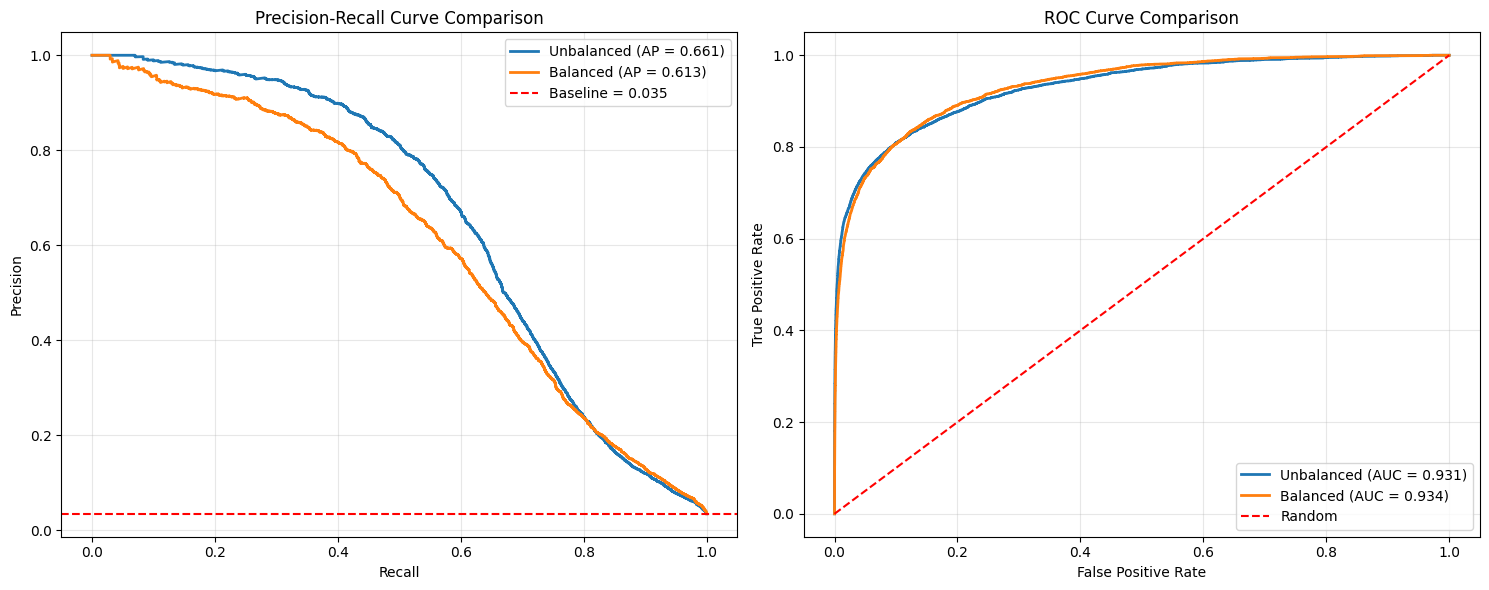

Spearman rho between score orderings: 0.960607341224481


{'unbalanced': {'auc': np.float64(0.931295114138382),
  'ap': np.float64(0.6610380511787444)},
 'balanced': {'auc': np.float64(0.9342028623079704),
  'ap': np.float64(0.6131903087815918)}}

In [8]:
# Only Sample Weight
xgb_pipe = XGBPipeline(X_train, X_val, y_train, y_val, dp.scaler, sample_weights=sample_weights, scale_pos_weight=None)
xgb_pipe.train_xgboost(n_estimators=1000, learning_rate=0.03, early_stopping_rounds=50)

compare_balanced_vs_unbalanced(
    X_val, y_val,
    balanced_model=xgb_pipe.model,
    unbalanced_model=xgb_pipe_unbal.model)

/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [21:24:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


Comparing balanced vs unbalanced approaches...
Unbalanced Model:
  AUC: 0.9313
  Average Precision: 0.6610

Balanced Model:
  AUC: 0.9342
  Average Precision: 0.6144

Improvement:
  AUC: +0.0029
  Average Precision: -0.0466 (-7.1%)


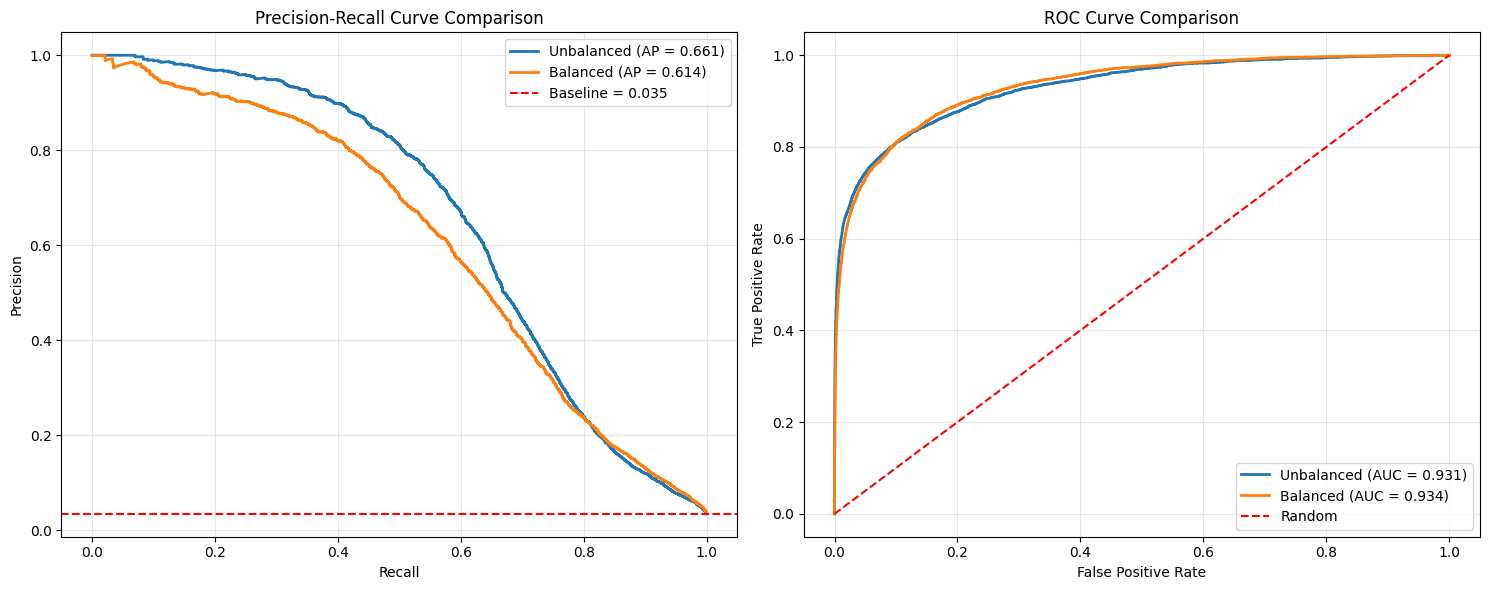

Spearman rho between score orderings: 0.9616080573170316


{'unbalanced': {'auc': np.float64(0.931295114138382),
  'ap': np.float64(0.6610380511787444)},
 'balanced': {'auc': np.float64(0.9341805126505738),
  'ap': np.float64(0.6144307315087447)}}

In [9]:
# Only Pos Weight
xgb_pipe = XGBPipeline(X_train, X_val, y_train, y_val, dp.scaler, sample_weights=None, scale_pos_weight=scale_pos)
xgb_pipe.train_xgboost(n_estimators=1000, learning_rate=0.03, early_stopping_rounds=50)

compare_balanced_vs_unbalanced(
    X_val, y_val,
    balanced_model=xgb_pipe.model,
    unbalanced_model=xgb_pipe_unbal.model)